# MODEL GLM1
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

# ROI mask specs:
### Hippocampus (FS labels: hippocampus [17, 53])
### Putamen (FS labels: putamen [12, 51])
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsal caudate (hand-drawn)

In [1]:
from os.path import join
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/data/mri/wmaze' 
mask_filenames = []
cope_files = []
for sub in subs:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' 
                               + sub + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    subjcopes_glob = glob(proj_dir + '/scndlvl/model_GLM1/' + sub + '/fixedfx/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    if len(cope_files[-1]) == 0:
        print(sub)

## Double-check the array indexing for masks and copes

In [ ]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7]) 

In [ ]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 

### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [2]:
all_data = {'subjid':[],
            'lhhp_all_before_B_corr':[], 'rhhp_all_before_B_corr':[], 
            'lhhp_all_before_B_incorr':[], 'rhhp_all_before_B_incorr':[],            
            'lhmpfc_all_before_B_corr':[], 'rhmpfc_all_before_B_corr':[], 
            'lhmpfc_all_before_B_incorr':[], 'rhmpfc_all_before_B_incorr':[],            
            'lhcaud_all_before_B_corr':[], 'rhcaud_all_before_B_corr':[], 
            'lhcaud_all_before_B_incorr':[], 'rhcaud_all_before_B_incorr':[],            
            'lhput_all_before_B_corr':[], 'rhput_all_before_B_corr':[], 
            'lhput_all_before_B_incorr':[], 'rhput_all_before_B_incorr':[]}

for i in range(len(subs)):
    all_data['subjid'].append(subs[i])
    #ROI masks
    lh_hp_img = nb.load(mask_filenames[i][2])
    rh_hp_img = nb.load(mask_filenames[i][11])
    lh_mpfc_img = nb.load(mask_filenames[i][4])
    rh_mpfc_img = nb.load(mask_filenames[i][13])
    lh_caud_img = nb.load(mask_filenames[i][7])
    rh_caud_img = nb.load(mask_filenames[i][8])
    lh_put_img = nb.load(mask_filenames[i][16])
    rh_put_img = nb.load(mask_filenames[i][17])
    #copes
    all_before_B_corr_img = nb.load(cope_files[i][0])
    all_before_B_incorr_img = nb.load(cope_files[i][1])    
    
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['all_before_B_corr', 'all_before_B_incorr']   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))
    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [4]:
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['all_before_B_corr', 'all_before_B_incorr']
for r in region:
    for l in learn_type:
        all_data_df['{0}_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                              + all_data_df['rh{0}_{1}'.format(r,l)])/2.

### Region-specific dataframes for producing plots

In [5]:
hp_plot = {}
mpfc_plot = {}
caud_plot = {}
put_plot = {}

for i in ['hp', 'mpfc', 'caud', 'put']:
    exec('{0}_plot["corr"] = all_data_df["{0}_all_before_B_corr"]'.format(i))
    exec('{0}_plot["incorr"] = all_data_df["{0}_all_before_B_incorr"]'.format(i))
    exec('{0}_plot_df = pd.DataFrame.from_dict({0}_plot)'.format(i))

# Hippocampus

Mean incorr:  -2.6919804126
STD incorr:  2.44782810569

Mean corr:  -1.59704501703
STD corr:  2.31140197913

T-test: HPC all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=3.2747548276522651, pvalue=0.0039855602311797411)
Cohen's d =  0.633986821002


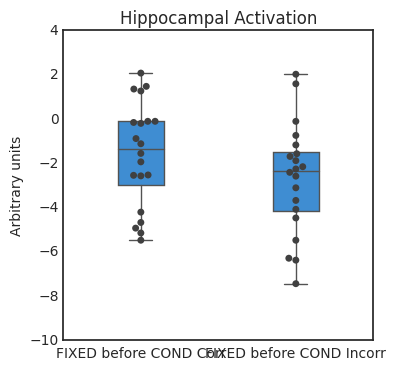

In [19]:
for key in hp_plot:
    print "Mean {0}: ".format(key), np.mean(hp_plot['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(hp_plot['{0}'.format(key)])
    print ""
cohens_d=((np.average(hp_plot['corr'])-np.average(hp_plot['incorr']))/(sqrt((np.std(hp_plot['corr'],ddof=1)) 
           **2+np.std(hp_plot['incorr'],ddof = 1)**2)/2))
print 'T-test: HPC all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(hp_plot['corr'], hp_plot['incorr'])
print "Cohen's d = ", cohens_d

N = 2
conditions = ['FIXED before COND Corr', 'FIXED before COND Incorr']
hp_allsubjs = [hp_plot['corr'], hp_plot['incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (4,4))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
#plt.savefig("/home/arenf001/HPC.png", dpi = 1080)
plt.show()

# Medial PFC

Mean incorr:  -1.9298172649
STD incorr:  3.48973610631

Mean corr:  -1.67383338958
STD corr:  3.53925372946

T-test: Medial PFC all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=0.81534729035922671, pvalue=0.42497698409713058)
Cohen's d =  0.1003958391


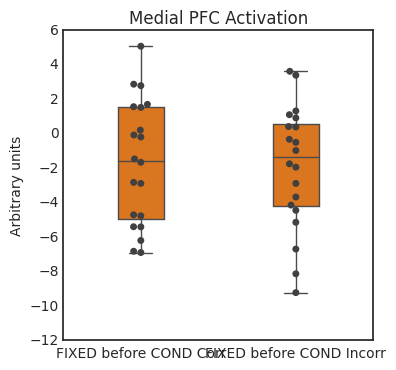

In [16]:
for key in mpfc_plot:
    print "Mean {0}: ".format(key), np.mean(mpfc_plot['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(mpfc_plot['{0}'.format(key)])
    print ""
cohens_d=((np.average(mpfc_plot['corr'])-np.average(mpfc_plot['incorr']))
          /(sqrt((np.std(mpfc_plot['corr'],ddof=1)) 
           **2+np.std(mpfc_plot['incorr'],ddof = 1)**2)/2))
print 'T-test: Medial PFC all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(mpfc_plot['corr'], mpfc_plot['incorr'])
print "Cohen's d = ", cohens_d

N = 2
conditions = ['FIXED before COND Corr', 'FIXED before COND Incorr']
mpfc_allsubjs = [mpfc_plot['corr'], mpfc_plot['incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (4,4))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#f97401", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
#plt.savefig("/home/arenf001/mPFC.png", dpi = 1080)
plt.show()

# Caudate

Mean incorr:  1.58275917358
STD incorr:  2.96191672966

Mean corr:  1.01567577012
STD corr:  2.93663706367

T-test: Caudate all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=-1.5093793742591588, pvalue=0.14765261278699937)
Cohen's d =  -0.265035592374


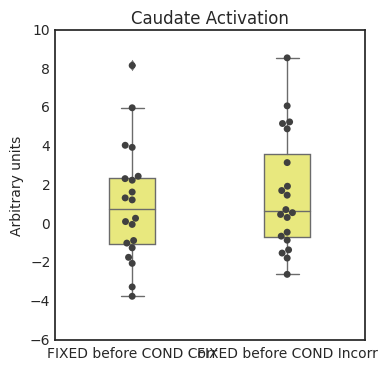

In [17]:
for key in caud_plot:
    print "Mean {0}: ".format(key), np.mean(caud_plot['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(caud_plot['{0}'.format(key)])
    print ""
cohens_d=((np.average(caud_plot['corr'])-np.average(caud_plot['incorr']))
          /(sqrt((np.std(caud_plot['corr'],ddof=1)) 
           **2+np.std(caud_plot['incorr'],ddof = 1)**2)/2))
print 'T-test: Caudate all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(caud_plot['corr'], caud_plot['incorr'])
print "Cohen's d = ", cohens_d

N = 2
conditions = ['FIXED before COND Corr', 'FIXED before COND Incorr']
caud_allsubjs = [caud_plot['corr'], caud_plot['incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (4,4))
ax0 = sns.boxplot(data = caud_allsubjs, color = "#f9f96d", width = 0.3)
ax2 = sns.swarmplot(data = caud_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
#plt.savefig("/home/arenf001/DAC.png", dpi = 1080)
plt.show()

# Putamen

Mean incorr:  -0.435632710904
STD incorr:  3.11503882595

Mean corr:  0.823882854357
STD corr:  3.02073009719

T-test: Putamen all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=3.2473426131790593, pvalue=0.004238959072392902)
Cohen's d =  0.565835309973


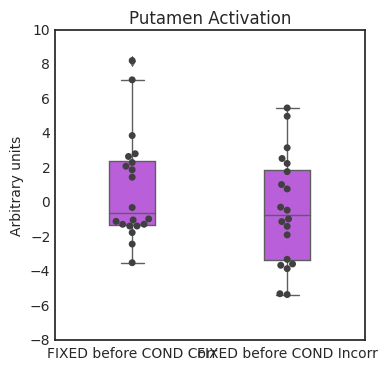

In [18]:
for key in put_plot:
    print "Mean {0}: ".format(key), np.mean(put_plot['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(put_plot['{0}'.format(key)])
    print ""
cohens_d=((np.average(put_plot['corr'])-np.average(put_plot['incorr']))/(sqrt((np.std(put_plot['corr'],ddof=1)) 
           **2+np.std(put_plot['incorr'],ddof = 1)**2)/2))
print 'T-test: Putamen all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(put_plot['corr'], put_plot['incorr'])
print "Cohen's d = ", cohens_d

N = 2
conditions = ['FIXED before COND Corr', 'FIXED before COND Incorr']
put_allsubjs = [put_plot['corr'], put_plot['incorr']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (4,4))
ax0 = sns.boxplot(data = put_allsubjs, color = "#c34aef", width = 0.3)
ax2 = sns.swarmplot(data = put_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
#plt.savefig("/home/arenf001/PUT.png", dpi = 1080)
plt.show()

# Scatterplots

## - Compares avg preceding fixed activation with avg performance on conditional trials

In [ ]:
all_prop_corr = []

for sub in subs:
    sub_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/'.format(sub)
    dir_file = glob(join(sub_dir, '{0}_wmazebl_2015*.txt'.format(sub)))   
    dir_file.sort()    
    
    run1 = pd.read_table(dir_file[0]) #open each run and cut off last three trials
    run1 = run1[:-3]
    run2 = pd.read_table(dir_file[1])
    run2 = run2[:-3]
    run3 = pd.read_table(dir_file[2])
    run3 = run3[:-3]
    run4 = pd.read_table(dir_file[3])
    run4 = run4[:-3]
    run5 = pd.read_table(dir_file[4])
    run5 = run5[:-3]
    run6 = pd.read_table(dir_file[5])
    run6 = run6[:-3]
    
    all_runs = [run1, run2, run3, run4, run5, run6] #concatenate all 6 runs   
    data_set = pd.concat(all_runs)
    
    trialtype = data_set['TrialType'].values #Numpy arrays for trial type and accuracy
    correct = data_set['Correct'].values 
    
    trial_shift = trialtype[:-1] #removing last trial and shifting down 
    trial_shift = np.insert(trial_shift, 0, -1)
    correct_shift = correct[:-1]
    correct_shift = np.insert(correct_shift, 0, -1)
    #grab indices for trials matching specified criteria
    corr = sorted(np.where(((trialtype == 'B') & (correct == 1)) & (trial_shift != 'BL'))[0])    
    incorr = sorted(np.where(((trialtype == 'B') & (correct == 0)) & (trial_shift != 'BL'))[0])      
    all_prop_corr.append(len(corr)/float(len(corr)+len(incorr))) #append proportion of correct trials

all_data_df['prop_corr'] = all_prop_corr

### Average regional activation across all trial types

In [ ]:
region = ['hp', 'mpfc', 'caud', 'put']
for r in region:
    all_data_df['{0}_all_before_B'.format(r,l)] = (all_data_df['lh{0}_all_before_B_corr'.format(r)] 
                                                   + all_data_df['rh{0}_all_before_B_corr'.format(r)]
                                                   + all_data_df['lh{0}_all_before_B_incorr'.format(r)] 
                                                   + all_data_df['rh{0}_all_before_B_incorr'.format(r)])/4.

## Hippocampus

In [ ]:
x = all_data_df['prop_corr']
y = all_data_df['hp_all_before_B']

print 'FIXED --> COND', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'hp_all_before_B', data = all_data_df)
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Hippocampus')
plt.show()

## mPFC

In [ ]:
x = all_data_df['prop_corr']
y = all_data_df['mpfc_all_before_B']

print 'FIXED --> COND', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'mpfc_all_before_B', color = '#f97401', data = all_data_df)
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('mPFC')
plt.show()

## Caudate

In [ ]:
x = all_data_df['prop_corr']
y = all_data_df['caud_all_before_B']

print 'FIXED --> COND', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'caud_all_before_B', color = "#f7e200", data = all_data_df)
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Caudate')
plt.show()

## Putamen

In [ ]:
x = all_data_df['prop_corr']
y = all_data_df['put_all_before_B']

print 'FIXED --> COND', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'put_all_before_B', color = "#c34aef", data = all_data_df)
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Putamen')
plt.show()